In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from IPython.display import display, HTML
import math

from utils.emissions_normalizer import EmissionsNormalizer

## Utils

In [4]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


def k_cross_validation(clf, data, target, get_classifier_mae, k=5):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(target, np.ndarray):
        target = np.array(target)
        
    kf = KFold(n_splits=k, shuffle=True)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        clf.fit(X_train, y_train)
        mae = get_classifier_mae(clf.predict(X_test), y_test)
        mae_train = get_classifier_mae(clf.predict(X_train), y_train)
        mae_list.append(mae)
        mae_list_train.append(mae_train)


    return mae_list, mae_list_train


def show_best_results(results, estimator_name, n=5):
    best_res = sc.sparkContext.parallelize(results).sortBy(lambda x: x['error']).take(n)
    df = pd.DataFrame(list(map(lambda x: x['params'], best_res)))
    df["mean_score_validation"] = list(map(lambda x: x['error'], best_res))
    df["mean_score_training"] = list(map(lambda x: x['error_train'], best_res))
    display(HTML("<h3> {}: top {} combinaciones  </h3>".format(estimator_name, n)))
    display(df.sort_values(by="mean_score_validation", ascending=True).head(n))
    
def regre_grid_search(predictor, params, regre_data, regre_target):
    results = []
    for params in ParameterGrid(params):
        clf = MultiOutputRegressor(predictor(**params))
        res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae)
        results.append({'params': params, 'error': np.mean(res_test), 'error_train': np.mean(res_train)})

    show_best_results(results, predictor.__name__)
    
def classi_grid_search(predictor, params, classi_data, classi_target):
    results = []
    for params in ParameterGrid(params):
        clf = predictor(**params)
        res_test, res_train = k_cross_validation(clf, classi_data, np.array(classi_target).ravel(), get_classifier_mae)
        results.append({'params': params, 'error': np.mean(res_test), 'error_train': np.mean(res_train)})

    show_best_results(results, predictor.__name__)
    
    
from sklearn.model_selection import GroupKFold



### deprecated
def k_cross_validation_separated_points(clf, data, target, get_classifier_mae, k=5):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(target, np.ndarray):
        target = np.array(target)
    
    unique_target = np.unique(target, axis=0)

    groups = []
    for h in range(len(target)):
        i,j = np.where(unique_target == target[h])
        if i[0] == i[1]:
            groups.append(i[0])
        else:
            raise Exception('Algo anda mal')

    kf = GroupKFold(n_splits=k)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data, groups=groups):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        clf.fit(X_train, y_train)
        mae = get_classifier_mae(clf.predict(X_test), y_test)
        mae_train = get_classifier_mae(clf.predict(X_train), y_train)
        mae_list.append(mae)
        mae_list_train.append(mae_train)


    return mae_list, mae_list_train



## Map utils

In [5]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 

global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd


normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [7]:
clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, weights='distance'))
#clf = KNeighborsRegressor(n_neighbors=5, weights='distance')



def get_regressor_mae(predictions, real):
    mae = 0
    for i in range(len(predictions)):
        mae += distance(predictions[i], real[i])
    mae = mae/len(predictions)
    return mae


res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=5)
np.mean(res_test)

334.3981191378863

In [9]:
from sklearn.neural_network import MLPRegressor

In [10]:
clf = MLPRegressor(hidden_layer_sizes=(4,4), max_iter=10000, learning_rate_init=0.001, verbose=True)

res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=5)
np.mean(res_test)

Iteration 1, loss = 1856715.12485223
Iteration 2, loss = 1850531.65139331
Iteration 3, loss = 1846213.40695861
Iteration 4, loss = 1842945.98256517
Iteration 5, loss = 1839453.88152482
Iteration 6, loss = 1835302.14302848
Iteration 7, loss = 1829988.51258828
Iteration 8, loss = 1823232.49994588
Iteration 9, loss = 1814736.06295089
Iteration 10, loss = 1803818.98443478
Iteration 11, loss = 1790193.92802528
Iteration 12, loss = 1773591.99848938
Iteration 13, loss = 1753219.36994795
Iteration 14, loss = 1728804.48667619
Iteration 15, loss = 1699820.31517125
Iteration 16, loss = 1665599.22148623
Iteration 17, loss = 1626374.34336805
Iteration 18, loss = 1582114.74384621
Iteration 19, loss = 1533716.89191239
Iteration 20, loss = 1481824.19123881
Iteration 21, loss = 1427369.83109304
Iteration 22, loss = 1371065.02065211
Iteration 23, loss = 1314261.21703391
Iteration 24, loss = 1256589.50597379
Iteration 25, loss = 1199352.94690824
Iteration 26, loss = 1144274.30235237
Iteration 27, loss = 

Iteration 230, loss = 267689.59656507
Iteration 231, loss = 267398.95988225
Iteration 232, loss = 267092.67543783
Iteration 233, loss = 266766.88857484
Iteration 234, loss = 266564.13536428
Iteration 235, loss = 266206.60810781
Iteration 236, loss = 265846.41502518
Iteration 237, loss = 265509.71712110
Iteration 238, loss = 265195.70427582
Iteration 239, loss = 264885.28047152
Iteration 240, loss = 264567.46682822
Iteration 241, loss = 264256.24043946
Iteration 242, loss = 263943.20057239
Iteration 243, loss = 263637.84357094
Iteration 244, loss = 263391.12564918
Iteration 245, loss = 263076.55273118
Iteration 246, loss = 262797.31610899
Iteration 247, loss = 262500.56506537
Iteration 248, loss = 262160.12521081
Iteration 249, loss = 261907.66504532
Iteration 250, loss = 261589.08350849
Iteration 251, loss = 261225.66390224
Iteration 252, loss = 260895.23976546
Iteration 253, loss = 260483.48481405
Iteration 254, loss = 259868.61996832
Iteration 255, loss = 258970.33371213
Iteration 25

Iteration 455, loss = 193810.33833384
Iteration 456, loss = 193333.41898433
Iteration 457, loss = 192906.74406785
Iteration 458, loss = 192459.10689145
Iteration 459, loss = 192033.10146062
Iteration 460, loss = 191606.64679537
Iteration 461, loss = 191135.91048529
Iteration 462, loss = 190703.27789880
Iteration 463, loss = 190216.45839688
Iteration 464, loss = 189772.04358397
Iteration 465, loss = 189273.59824211
Iteration 466, loss = 188877.36750371
Iteration 467, loss = 188385.73245277
Iteration 468, loss = 187856.77228102
Iteration 469, loss = 187388.55720952
Iteration 470, loss = 186976.02011188
Iteration 471, loss = 186417.31401755
Iteration 472, loss = 185963.55265680
Iteration 473, loss = 185465.80454721
Iteration 474, loss = 184972.68666767
Iteration 475, loss = 184563.95476693
Iteration 476, loss = 184017.57255366
Iteration 477, loss = 183553.49714519
Iteration 478, loss = 183017.70410853
Iteration 479, loss = 182512.96258046
Iteration 480, loss = 181983.57516256
Iteration 48

Iteration 677, loss = 54835.02644994
Iteration 678, loss = 54768.96114342
Iteration 679, loss = 54690.53715433
Iteration 680, loss = 54594.76010685
Iteration 681, loss = 54547.34297731
Iteration 682, loss = 54450.83276346
Iteration 683, loss = 54395.19216408
Iteration 684, loss = 54304.26160684
Iteration 685, loss = 54228.79100415
Iteration 686, loss = 54162.88108519
Iteration 687, loss = 54108.93443310
Iteration 688, loss = 53985.19048690
Iteration 689, loss = 53914.81842488
Iteration 690, loss = 53838.79677434
Iteration 691, loss = 53724.96352018
Iteration 692, loss = 53670.32981212
Iteration 693, loss = 53678.44165806
Iteration 694, loss = 53541.26475447
Iteration 695, loss = 53453.29234018
Iteration 696, loss = 53384.29904985
Iteration 697, loss = 53353.07797598
Iteration 698, loss = 53266.88101261
Iteration 699, loss = 53250.50937758
Iteration 700, loss = 53165.69608731
Iteration 701, loss = 53109.05992651
Iteration 702, loss = 53155.64904594
Iteration 703, loss = 53112.24138387
I

Iteration 909, loss = 47115.46413144
Iteration 910, loss = 47057.28269923
Iteration 911, loss = 47059.89288086
Iteration 912, loss = 47073.56686402
Iteration 913, loss = 47044.08138741
Iteration 914, loss = 46893.96910068
Iteration 915, loss = 46876.05592604
Iteration 916, loss = 46816.96587312
Iteration 917, loss = 46836.28329552
Iteration 918, loss = 46788.43047259
Iteration 919, loss = 46735.58078130
Iteration 920, loss = 46716.88188353
Iteration 921, loss = 46699.97447323
Iteration 922, loss = 46656.79866680
Iteration 923, loss = 46632.74711616
Iteration 924, loss = 46605.67966385
Iteration 925, loss = 46586.80668054
Iteration 926, loss = 46542.02594688
Iteration 927, loss = 46494.62402551
Iteration 928, loss = 46587.67958500
Iteration 929, loss = 46533.67021374
Iteration 930, loss = 46499.65557860
Iteration 931, loss = 46419.71208848
Iteration 932, loss = 46415.01646686
Iteration 933, loss = 46384.19780675
Iteration 934, loss = 46370.73941068
Iteration 935, loss = 46330.72068886
I

Iteration 1146, loss = 43481.55286930
Iteration 1147, loss = 43437.62133534
Iteration 1148, loss = 43387.85605412
Iteration 1149, loss = 43380.98582219
Iteration 1150, loss = 43372.78542783
Iteration 1151, loss = 43341.14484867
Iteration 1152, loss = 43343.68186033
Iteration 1153, loss = 43376.74310204
Iteration 1154, loss = 43296.97442168
Iteration 1155, loss = 43324.81741626
Iteration 1156, loss = 43280.20671582
Iteration 1157, loss = 43292.32226036
Iteration 1158, loss = 43308.27366977
Iteration 1159, loss = 43260.93480163
Iteration 1160, loss = 43241.52019360
Iteration 1161, loss = 43240.56067497
Iteration 1162, loss = 43289.79505121
Iteration 1163, loss = 43220.45192872
Iteration 1164, loss = 43177.82203211
Iteration 1165, loss = 43227.48946892
Iteration 1166, loss = 43201.76766981
Iteration 1167, loss = 43173.92406190
Iteration 1168, loss = 43155.78136174
Iteration 1169, loss = 43170.34465058
Iteration 1170, loss = 43152.40236549
Iteration 1171, loss = 43121.20280798
Iteration 11

Iteration 1381, loss = 41650.14941968
Iteration 1382, loss = 41648.01564088
Iteration 1383, loss = 41651.55232561
Iteration 1384, loss = 41639.45499729
Iteration 1385, loss = 41647.72713343
Iteration 1386, loss = 41622.71813954
Iteration 1387, loss = 41631.67979746
Iteration 1388, loss = 41628.65781363
Iteration 1389, loss = 41616.56312357
Iteration 1390, loss = 41603.41172451
Iteration 1391, loss = 41594.92161409
Iteration 1392, loss = 41605.59251095
Iteration 1393, loss = 41596.78985242
Iteration 1394, loss = 41596.26484442
Iteration 1395, loss = 41637.25251039
Iteration 1396, loss = 41580.18802235
Iteration 1397, loss = 41563.81353772
Iteration 1398, loss = 41586.70093035
Iteration 1399, loss = 41618.57615397
Iteration 1400, loss = 41563.93304151
Iteration 1401, loss = 41553.51645314
Iteration 1402, loss = 41558.99964208
Iteration 1403, loss = 41564.79520609
Iteration 1404, loss = 41583.61425341
Iteration 1405, loss = 41593.22136819
Iteration 1406, loss = 41563.14831148
Iteration 14

Iteration 114, loss = 330842.95683920
Iteration 115, loss = 330627.64523595
Iteration 116, loss = 330375.78285273
Iteration 117, loss = 330104.27189651
Iteration 118, loss = 329851.83432119
Iteration 119, loss = 329643.55123009
Iteration 120, loss = 329360.97855887
Iteration 121, loss = 329123.40030579
Iteration 122, loss = 328885.58767047
Iteration 123, loss = 328650.74271695
Iteration 124, loss = 328424.17480985
Iteration 125, loss = 328173.88740718
Iteration 126, loss = 327957.93750297
Iteration 127, loss = 327698.81464028
Iteration 128, loss = 327504.86599248
Iteration 129, loss = 327272.90434673
Iteration 130, loss = 326988.61299988
Iteration 131, loss = 326721.46313380
Iteration 132, loss = 326500.83173044
Iteration 133, loss = 326292.90077519
Iteration 134, loss = 326042.96248216
Iteration 135, loss = 325820.14988781
Iteration 136, loss = 325584.04878486
Iteration 137, loss = 325336.58815257
Iteration 138, loss = 325091.87006033
Iteration 139, loss = 324829.91649867
Iteration 14

Iteration 337, loss = 222477.08770118
Iteration 338, loss = 221849.62040227
Iteration 339, loss = 221270.45301825
Iteration 340, loss = 220720.50020060
Iteration 341, loss = 220241.99803868
Iteration 342, loss = 219748.18937446
Iteration 343, loss = 219233.39851069
Iteration 344, loss = 218743.23732401
Iteration 345, loss = 218271.27968371
Iteration 346, loss = 217830.35928767
Iteration 347, loss = 217332.33305318
Iteration 348, loss = 216925.29363323
Iteration 349, loss = 216420.47954372
Iteration 350, loss = 216036.26434136
Iteration 351, loss = 215627.02653080
Iteration 352, loss = 215128.42768157
Iteration 353, loss = 214712.08878284
Iteration 354, loss = 214323.97862897
Iteration 355, loss = 213842.40148082
Iteration 356, loss = 213435.56803344
Iteration 357, loss = 212967.01970300
Iteration 358, loss = 212602.43312979
Iteration 359, loss = 212187.35398338
Iteration 360, loss = 211693.23985847
Iteration 361, loss = 211361.61330014
Iteration 362, loss = 210936.36360830
Iteration 36

Iteration 579, loss = 70467.32503129
Iteration 580, loss = 70006.11747326
Iteration 581, loss = 69572.27184252
Iteration 582, loss = 69059.97556744
Iteration 583, loss = 68572.27824933
Iteration 584, loss = 68111.49712237
Iteration 585, loss = 67800.75950682
Iteration 586, loss = 67395.61830365
Iteration 587, loss = 67098.25944077
Iteration 588, loss = 66807.13597339
Iteration 589, loss = 66530.98663118
Iteration 590, loss = 66205.89797415
Iteration 591, loss = 65891.41030866
Iteration 592, loss = 65578.75973197
Iteration 593, loss = 65316.90618134
Iteration 594, loss = 65100.07813493
Iteration 595, loss = 64831.35764027
Iteration 596, loss = 64622.01808645
Iteration 597, loss = 64365.31996769
Iteration 598, loss = 64132.95171101
Iteration 599, loss = 63925.68427234
Iteration 600, loss = 63698.60624907
Iteration 601, loss = 63468.72802633
Iteration 602, loss = 63215.88561703
Iteration 603, loss = 63021.47690408
Iteration 604, loss = 62790.87443802
Iteration 605, loss = 62611.22263019
I

Iteration 825, loss = 47851.88604508
Iteration 826, loss = 47793.04283092
Iteration 827, loss = 47751.96849307
Iteration 828, loss = 47724.88732439
Iteration 829, loss = 47692.54254584
Iteration 830, loss = 47699.32990627
Iteration 831, loss = 47616.77155776
Iteration 832, loss = 47626.27760710
Iteration 833, loss = 47559.16950006
Iteration 834, loss = 47526.06869580
Iteration 835, loss = 47498.88836379
Iteration 836, loss = 47430.20974659
Iteration 837, loss = 47394.47120246
Iteration 838, loss = 47394.62957238
Iteration 839, loss = 47401.48092598
Iteration 840, loss = 47369.12576937
Iteration 841, loss = 47300.38025539
Iteration 842, loss = 47253.69037476
Iteration 843, loss = 47237.05795217
Iteration 844, loss = 47211.05849549
Iteration 845, loss = 47155.40899919
Iteration 846, loss = 47144.63218482
Iteration 847, loss = 47065.47530015
Iteration 848, loss = 47059.20375335
Iteration 849, loss = 46998.14988938
Iteration 850, loss = 46982.56332302
Iteration 851, loss = 47003.42792984
I

Iteration 1061, loss = 43465.49258450
Iteration 1062, loss = 43482.03868401
Iteration 1063, loss = 43506.46729673
Iteration 1064, loss = 43445.22136530
Iteration 1065, loss = 43486.05440265
Iteration 1066, loss = 43481.94339892
Iteration 1067, loss = 43414.81867769
Iteration 1068, loss = 43430.94971103
Iteration 1069, loss = 43474.88418418
Iteration 1070, loss = 43444.15464877
Iteration 1071, loss = 43429.38086850
Iteration 1072, loss = 43421.63753693
Iteration 1073, loss = 43396.95531574
Iteration 1074, loss = 43405.99839312
Iteration 1075, loss = 43387.86313106
Iteration 1076, loss = 43380.82383766
Iteration 1077, loss = 43360.27465633
Iteration 1078, loss = 43370.38768704
Iteration 1079, loss = 43379.66366182
Iteration 1080, loss = 43385.23857355
Iteration 1081, loss = 43425.41299619
Iteration 1082, loss = 43389.56834649
Iteration 1083, loss = 43370.15455873
Iteration 1084, loss = 43356.82524667
Iteration 1085, loss = 43324.73370690
Iteration 1086, loss = 43339.90243668
Iteration 10

Iteration 1286, loss = 42828.84029902
Iteration 1287, loss = 42808.75849486
Iteration 1288, loss = 42821.14707641
Iteration 1289, loss = 42874.33358979
Iteration 1290, loss = 42803.99367900
Iteration 1291, loss = 42844.17236197
Iteration 1292, loss = 42777.34150457
Iteration 1293, loss = 42813.37651313
Iteration 1294, loss = 42804.54944641
Iteration 1295, loss = 42774.86730068
Iteration 1296, loss = 42801.15187877
Iteration 1297, loss = 42792.82701214
Iteration 1298, loss = 42777.18252637
Iteration 1299, loss = 42818.31095243
Iteration 1300, loss = 42819.21810821
Iteration 1301, loss = 42785.04548107
Iteration 1302, loss = 42780.65799111
Iteration 1303, loss = 42810.98448620
Iteration 1304, loss = 42819.97121712
Iteration 1305, loss = 42770.41704391
Iteration 1306, loss = 42769.65488024
Iteration 1307, loss = 42759.28024365
Iteration 1308, loss = 42762.55564064
Iteration 1309, loss = 42773.07227602
Iteration 1310, loss = 42762.83436553
Iteration 1311, loss = 42778.60496086
Iteration 13

Iteration 80, loss = 378901.21834768
Iteration 81, loss = 376695.24606323
Iteration 82, loss = 374712.35089476
Iteration 83, loss = 372917.38790140
Iteration 84, loss = 371273.20052131
Iteration 85, loss = 369790.89226710
Iteration 86, loss = 368509.08454055
Iteration 87, loss = 367325.85946358
Iteration 88, loss = 366296.22360242
Iteration 89, loss = 365324.38146917
Iteration 90, loss = 364437.26950133
Iteration 91, loss = 363633.96217646
Iteration 92, loss = 362880.28578953
Iteration 93, loss = 362199.48967201
Iteration 94, loss = 361598.26524413
Iteration 95, loss = 361000.86745739
Iteration 96, loss = 360509.05477803
Iteration 97, loss = 360008.24582438
Iteration 98, loss = 359562.38065104
Iteration 99, loss = 359137.62978329
Iteration 100, loss = 358763.80543086
Iteration 101, loss = 358397.55150659
Iteration 102, loss = 358066.81044648
Iteration 103, loss = 357764.09679593
Iteration 104, loss = 357469.61028658
Iteration 105, loss = 357181.67384412
Iteration 106, loss = 356914.089

Iteration 320, loss = 272584.58599274
Iteration 321, loss = 272162.68013215
Iteration 322, loss = 271725.09489523
Iteration 323, loss = 271299.60653456
Iteration 324, loss = 270856.66139731
Iteration 325, loss = 270383.80999669
Iteration 326, loss = 269931.14563948
Iteration 327, loss = 269483.75267980
Iteration 328, loss = 269046.99487259
Iteration 329, loss = 268560.74622511
Iteration 330, loss = 268097.42446341
Iteration 331, loss = 267646.80794355
Iteration 332, loss = 267207.15099704
Iteration 333, loss = 266703.25046538
Iteration 334, loss = 266240.37008107
Iteration 335, loss = 265781.45627178
Iteration 336, loss = 265341.04735130
Iteration 337, loss = 264939.29082684
Iteration 338, loss = 264564.45884044
Iteration 339, loss = 264124.30549892
Iteration 340, loss = 263720.01812430
Iteration 341, loss = 263354.75314140
Iteration 342, loss = 262945.74991227
Iteration 343, loss = 262558.06839813
Iteration 344, loss = 262167.10897540
Iteration 345, loss = 261790.19699183
Iteration 34

Iteration 552, loss = 156521.25492755
Iteration 553, loss = 156076.51062804
Iteration 554, loss = 155563.32095313
Iteration 555, loss = 155120.58107685
Iteration 556, loss = 154680.54311788
Iteration 557, loss = 154267.84547349
Iteration 558, loss = 153759.46245262
Iteration 559, loss = 153319.69220989
Iteration 560, loss = 152891.11020245
Iteration 561, loss = 152458.44976038
Iteration 562, loss = 151985.63626250
Iteration 563, loss = 151532.56292013
Iteration 564, loss = 151120.52257351
Iteration 565, loss = 150646.82639494
Iteration 566, loss = 150271.18024619
Iteration 567, loss = 149788.57133058
Iteration 568, loss = 149364.46899647
Iteration 569, loss = 148884.66112908
Iteration 570, loss = 148532.90376219
Iteration 571, loss = 148006.51467802
Iteration 572, loss = 147661.55278781
Iteration 573, loss = 147164.31613386
Iteration 574, loss = 146716.06328999
Iteration 575, loss = 146298.72216312
Iteration 576, loss = 145852.38221389
Iteration 577, loss = 145417.12402078
Iteration 57

Iteration 770, loss = 72839.11447736
Iteration 771, loss = 72244.37579715
Iteration 772, loss = 71744.85431476
Iteration 773, loss = 71057.09158996
Iteration 774, loss = 70154.88361222
Iteration 775, loss = 69343.38386407
Iteration 776, loss = 68656.23033160
Iteration 777, loss = 68169.55414633
Iteration 778, loss = 67570.00153077
Iteration 779, loss = 67095.26842337
Iteration 780, loss = 66745.01986690
Iteration 781, loss = 66240.32158682
Iteration 782, loss = 65815.17019374
Iteration 783, loss = 65379.67366272
Iteration 784, loss = 64995.24964911
Iteration 785, loss = 64600.18898052
Iteration 786, loss = 64245.51472363
Iteration 787, loss = 63820.36699344
Iteration 788, loss = 63437.75623669
Iteration 789, loss = 63118.93190895
Iteration 790, loss = 62665.79529268
Iteration 791, loss = 62277.12540797
Iteration 792, loss = 61817.42818230
Iteration 793, loss = 61398.61452414
Iteration 794, loss = 60963.49799488
Iteration 795, loss = 60474.82478348
Iteration 796, loss = 60020.57672142
I

Iteration 1011, loss = 49030.95621407
Iteration 1012, loss = 49078.94430664
Iteration 1013, loss = 49012.60938698
Iteration 1014, loss = 49018.53768698
Iteration 1015, loss = 49016.89585031
Iteration 1016, loss = 49037.70441853
Iteration 1017, loss = 49011.53083803
Iteration 1018, loss = 49027.05523622
Iteration 1019, loss = 49002.72587283
Iteration 1020, loss = 48980.70338961
Iteration 1021, loss = 48972.35809165
Iteration 1022, loss = 48979.40977064
Iteration 1023, loss = 49009.70762188
Iteration 1024, loss = 48983.17132435
Iteration 1025, loss = 49010.49330089
Iteration 1026, loss = 48979.05057354
Iteration 1027, loss = 48972.17650013
Iteration 1028, loss = 48965.19174693
Iteration 1029, loss = 48957.32544174
Iteration 1030, loss = 48958.70677413
Iteration 1031, loss = 48963.82510533
Iteration 1032, loss = 49052.42701971
Iteration 1033, loss = 48959.88397135
Iteration 1034, loss = 48954.53495068
Iteration 1035, loss = 48930.10415594
Iteration 1036, loss = 48989.31368725
Iteration 10

Iteration 169, loss = 374172.81508473
Iteration 170, loss = 374066.28152204
Iteration 171, loss = 373999.80065674
Iteration 172, loss = 373818.14526979
Iteration 173, loss = 373684.99851777
Iteration 174, loss = 373556.10069426
Iteration 175, loss = 373426.63167758
Iteration 176, loss = 373293.14519578
Iteration 177, loss = 373178.08706276
Iteration 178, loss = 373064.51613075
Iteration 179, loss = 372965.53025780
Iteration 180, loss = 372822.09588663
Iteration 181, loss = 372694.57894625
Iteration 182, loss = 372596.28186318
Iteration 183, loss = 372418.41130312
Iteration 184, loss = 372295.57080649
Iteration 185, loss = 372170.93725169
Iteration 186, loss = 372083.00630113
Iteration 187, loss = 371929.27086576
Iteration 188, loss = 371787.46717624
Iteration 189, loss = 371637.40885682
Iteration 190, loss = 371583.68078860
Iteration 191, loss = 371389.59090393
Iteration 192, loss = 371261.75809668
Iteration 193, loss = 371118.08705203
Iteration 194, loss = 370992.51225209
Iteration 19

Iteration 387, loss = 309548.34667109
Iteration 388, loss = 308497.82140371
Iteration 389, loss = 307031.36085506
Iteration 390, loss = 305661.70840333
Iteration 391, loss = 304343.54576981
Iteration 392, loss = 303187.54352857
Iteration 393, loss = 302004.74426752
Iteration 394, loss = 300876.43625039
Iteration 395, loss = 299825.70192720
Iteration 396, loss = 298749.14725717
Iteration 397, loss = 297661.33749338
Iteration 398, loss = 296632.92326107
Iteration 399, loss = 295597.28888231
Iteration 400, loss = 294304.17394010
Iteration 401, loss = 291850.84084185
Iteration 402, loss = 288140.86808235
Iteration 403, loss = 284469.24361054
Iteration 404, loss = 281497.33871911
Iteration 405, loss = 279234.73198457
Iteration 406, loss = 277143.23911798
Iteration 407, loss = 275469.58061937
Iteration 408, loss = 273905.26947674
Iteration 409, loss = 272429.03242012
Iteration 410, loss = 270989.73314348
Iteration 411, loss = 269569.26465955
Iteration 412, loss = 268266.34393129
Iteration 41

Iteration 617, loss = 63412.99458181
Iteration 618, loss = 63176.20544575
Iteration 619, loss = 63018.43550292
Iteration 620, loss = 62811.36674967
Iteration 621, loss = 62644.41355161
Iteration 622, loss = 62474.70913322
Iteration 623, loss = 62304.08159742
Iteration 624, loss = 62149.36521718
Iteration 625, loss = 62001.57010366
Iteration 626, loss = 61865.61526028
Iteration 627, loss = 61612.89855944
Iteration 628, loss = 61471.99770644
Iteration 629, loss = 61392.46019783
Iteration 630, loss = 61207.35223812
Iteration 631, loss = 61078.60750594
Iteration 632, loss = 60940.03684211
Iteration 633, loss = 60764.06590566
Iteration 634, loss = 60652.90333914
Iteration 635, loss = 60523.78195565
Iteration 636, loss = 60418.07677006
Iteration 637, loss = 60266.22593861
Iteration 638, loss = 60145.95793010
Iteration 639, loss = 60041.99744366
Iteration 640, loss = 59975.60282293
Iteration 641, loss = 59804.26650068
Iteration 642, loss = 59685.54424896
Iteration 643, loss = 59572.18490045
I

Iteration 841, loss = 47550.46398388
Iteration 842, loss = 47524.63883299
Iteration 843, loss = 47507.69525641
Iteration 844, loss = 47520.82247921
Iteration 845, loss = 47478.57670123
Iteration 846, loss = 47467.55701519
Iteration 847, loss = 47450.36614175
Iteration 848, loss = 47474.43397164
Iteration 849, loss = 47440.82776188
Iteration 850, loss = 47429.32118111
Iteration 851, loss = 47398.50412504
Iteration 852, loss = 47411.14154916
Iteration 853, loss = 47425.89304849
Iteration 854, loss = 47392.57199312
Iteration 855, loss = 47351.86621851
Iteration 856, loss = 47348.78639986
Iteration 857, loss = 47361.36518779
Iteration 858, loss = 47346.14159161
Iteration 859, loss = 47307.54575620
Iteration 860, loss = 47332.43658700
Iteration 861, loss = 47364.05946383
Iteration 862, loss = 47279.38108423
Iteration 863, loss = 47242.03116537
Iteration 864, loss = 47245.40465212
Iteration 865, loss = 47219.78019581
Iteration 866, loss = 47236.92548606
Iteration 867, loss = 47252.10059156
I

Iteration 1069, loss = 45326.17239651
Iteration 1070, loss = 45396.41529359
Iteration 1071, loss = 45364.78836635
Iteration 1072, loss = 45350.39799444
Iteration 1073, loss = 45365.31655575
Iteration 1074, loss = 45355.73059058
Iteration 1075, loss = 45329.60886800
Iteration 1076, loss = 45334.20584319
Iteration 1077, loss = 45374.76047044
Iteration 1078, loss = 45453.83015461
Iteration 1079, loss = 45326.89687621
Iteration 1080, loss = 45310.97306413
Iteration 1081, loss = 45296.41951691
Iteration 1082, loss = 45297.99261220
Iteration 1083, loss = 45314.32013179
Iteration 1084, loss = 45365.63301054
Iteration 1085, loss = 45296.09912727
Iteration 1086, loss = 45297.37396881
Iteration 1087, loss = 45286.12172880
Iteration 1088, loss = 45262.70685472
Iteration 1089, loss = 45240.73919173
Iteration 1090, loss = 45246.86411192
Iteration 1091, loss = 45284.89285702
Iteration 1092, loss = 45300.32853259
Iteration 1093, loss = 45239.10717463
Iteration 1094, loss = 45287.80084905
Iteration 10

Iteration 1305, loss = 44442.83050513
Iteration 1306, loss = 44450.24426573
Iteration 1307, loss = 44440.52863014
Iteration 1308, loss = 44411.04807464
Iteration 1309, loss = 44504.21554433
Iteration 1310, loss = 44383.67919657
Iteration 1311, loss = 44426.67112844
Iteration 1312, loss = 44397.20666925
Iteration 1313, loss = 44395.80301758
Iteration 1314, loss = 44372.77993207
Iteration 1315, loss = 44385.81847609
Iteration 1316, loss = 44407.31601299
Iteration 1317, loss = 44375.66075996
Iteration 1318, loss = 44380.94733113
Iteration 1319, loss = 44412.24251027
Iteration 1320, loss = 44385.54262283
Iteration 1321, loss = 44359.93246364
Iteration 1322, loss = 44375.56441444
Iteration 1323, loss = 44350.13711796
Iteration 1324, loss = 44409.36685099
Iteration 1325, loss = 44371.05042921
Iteration 1326, loss = 44342.99059015
Iteration 1327, loss = 44329.38074748
Iteration 1328, loss = 44364.85834086
Iteration 1329, loss = 44383.43620527
Iteration 1330, loss = 44355.56758768
Iteration 13

Iteration 72, loss = 370335.43289130
Iteration 73, loss = 368572.65537545
Iteration 74, loss = 366868.02555079
Iteration 75, loss = 365211.96647217
Iteration 76, loss = 363681.63184018
Iteration 77, loss = 362033.19947697
Iteration 78, loss = 360552.18194312
Iteration 79, loss = 359073.20219642
Iteration 80, loss = 357646.02212488
Iteration 81, loss = 356248.27732976
Iteration 82, loss = 354916.35341036
Iteration 83, loss = 353587.96961592
Iteration 84, loss = 352284.80799832
Iteration 85, loss = 351023.69806485
Iteration 86, loss = 349759.23115938
Iteration 87, loss = 348541.30078039
Iteration 88, loss = 347366.15407560
Iteration 89, loss = 346177.44500604
Iteration 90, loss = 345051.55494123
Iteration 91, loss = 343880.42901396
Iteration 92, loss = 342802.30060932
Iteration 93, loss = 341659.70439205
Iteration 94, loss = 340637.08905585
Iteration 95, loss = 339591.83146301
Iteration 96, loss = 338519.71888039
Iteration 97, loss = 337504.48399126
Iteration 98, loss = 336499.51189550
I

Iteration 301, loss = 241807.87722136
Iteration 302, loss = 241551.10149683
Iteration 303, loss = 241297.83608213
Iteration 304, loss = 240995.62201814
Iteration 305, loss = 240753.39369718
Iteration 306, loss = 240481.31589941
Iteration 307, loss = 240215.77859237
Iteration 308, loss = 239936.19527279
Iteration 309, loss = 239747.63151491
Iteration 310, loss = 239347.71531426
Iteration 311, loss = 239096.73381294
Iteration 312, loss = 238826.17196212
Iteration 313, loss = 238586.07806524
Iteration 314, loss = 238340.41189486
Iteration 315, loss = 237993.02824609
Iteration 316, loss = 237725.01584980
Iteration 317, loss = 237431.27369347
Iteration 318, loss = 237169.64604398
Iteration 319, loss = 236898.39072275
Iteration 320, loss = 236629.80050146
Iteration 321, loss = 236333.46659369
Iteration 322, loss = 236085.10460265
Iteration 323, loss = 235822.65161906
Iteration 324, loss = 235513.83366078
Iteration 325, loss = 235242.71937319
Iteration 326, loss = 234964.26614181
Iteration 32

Iteration 543, loss = 104685.81654129
Iteration 544, loss = 103795.42877078
Iteration 545, loss = 102992.99380347
Iteration 546, loss = 102156.90897040
Iteration 547, loss = 101257.33225425
Iteration 548, loss = 100476.27734829
Iteration 549, loss = 99771.47725311
Iteration 550, loss = 99008.26043306
Iteration 551, loss = 98318.20846124
Iteration 552, loss = 97568.15845785
Iteration 553, loss = 96890.61508252
Iteration 554, loss = 96175.90139850
Iteration 555, loss = 95477.92955867
Iteration 556, loss = 94830.55231130
Iteration 557, loss = 94153.51347184
Iteration 558, loss = 93451.04914617
Iteration 559, loss = 92728.59418111
Iteration 560, loss = 92009.50206290
Iteration 561, loss = 91395.33437732
Iteration 562, loss = 90757.47385146
Iteration 563, loss = 90062.29218768
Iteration 564, loss = 89566.21651452
Iteration 565, loss = 88844.93528536
Iteration 566, loss = 88226.62561341
Iteration 567, loss = 87537.97393598
Iteration 568, loss = 86947.15985320
Iteration 569, loss = 86266.6140

Iteration 777, loss = 47342.14214112
Iteration 778, loss = 47364.24985781
Iteration 779, loss = 47333.79945812
Iteration 780, loss = 47277.18265483
Iteration 781, loss = 47278.15600845
Iteration 782, loss = 47270.17971703
Iteration 783, loss = 47265.99053139
Iteration 784, loss = 47241.40211440
Iteration 785, loss = 47249.82161841
Iteration 786, loss = 47172.12973818
Iteration 787, loss = 47166.23326309
Iteration 788, loss = 47206.50942009
Iteration 789, loss = 47175.16821585
Iteration 790, loss = 47155.98401775
Iteration 791, loss = 47122.97217396
Iteration 792, loss = 47084.29771043
Iteration 793, loss = 47068.96152270
Iteration 794, loss = 47090.32165513
Iteration 795, loss = 47049.66224527
Iteration 796, loss = 47077.24749624
Iteration 797, loss = 47019.81961404
Iteration 798, loss = 47116.95589779
Iteration 799, loss = 47010.98945640
Iteration 800, loss = 47047.33506990
Iteration 801, loss = 46975.09780315
Iteration 802, loss = 46932.89087444
Iteration 803, loss = 46932.45471884
I

Iteration 1011, loss = 44480.11846907
Iteration 1012, loss = 44427.23871527
Iteration 1013, loss = 44426.64093813
Iteration 1014, loss = 44427.40335542
Iteration 1015, loss = 44457.55235741
Iteration 1016, loss = 44417.95585061
Iteration 1017, loss = 44410.34053795
Iteration 1018, loss = 44402.55736471
Iteration 1019, loss = 44406.81246354
Iteration 1020, loss = 44392.18684256
Iteration 1021, loss = 44359.37637901
Iteration 1022, loss = 44414.76336985
Iteration 1023, loss = 44400.32901830
Iteration 1024, loss = 44362.89471208
Iteration 1025, loss = 44361.71963564
Iteration 1026, loss = 44338.46625284
Iteration 1027, loss = 44335.17488354
Iteration 1028, loss = 44342.36181199
Iteration 1029, loss = 44315.27247501
Iteration 1030, loss = 44311.10760571
Iteration 1031, loss = 44356.74045758
Iteration 1032, loss = 44304.28439647
Iteration 1033, loss = 44341.04143595
Iteration 1034, loss = 44327.92343166
Iteration 1035, loss = 44305.14113476
Iteration 1036, loss = 44267.81322711
Iteration 10

Iteration 1246, loss = 43318.80709259
Iteration 1247, loss = 43304.59812268
Iteration 1248, loss = 43269.46843236
Iteration 1249, loss = 43259.66051849
Iteration 1250, loss = 43236.44877392
Iteration 1251, loss = 43249.34613465
Iteration 1252, loss = 43227.70109157
Iteration 1253, loss = 43248.59744350
Iteration 1254, loss = 43279.91554970
Iteration 1255, loss = 43226.30807694
Iteration 1256, loss = 43215.72107182
Iteration 1257, loss = 43241.01776228
Iteration 1258, loss = 43234.54133709
Iteration 1259, loss = 43245.13656350
Iteration 1260, loss = 43245.61225813
Iteration 1261, loss = 43232.75361104
Iteration 1262, loss = 43205.82634509
Iteration 1263, loss = 43214.66328236
Iteration 1264, loss = 43195.34984058
Iteration 1265, loss = 43208.30039828
Iteration 1266, loss = 43245.22622620
Iteration 1267, loss = 43217.50558510
Iteration 1268, loss = 43242.28942199
Iteration 1269, loss = 43238.70711273
Iteration 1270, loss = 43214.27801393
Iteration 1271, loss = 43182.78124948
Iteration 12

366.192230538397

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
clf = MultiOutputRegressor(GradientBoostingRegressor())


res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=5)
np.mean(res_test)


322.53289186796775

### Clasificacion de puntos

In [12]:
classi_data, classi_target = normalizer.get_classification_dataframes(data)

In [13]:
global dict_coordenadas
dict_coordenadas = points_recep.map(lambda x: (x['Punto'],(x['x'], x['y']))).collectAsMap()



def get_classifier_mae(predictions, real):
    sum_error = 0
    count = 0
    for i in range(len(predictions)):
        pred_position = dict_coordenadas[predictions[i]]
        real_position = dict_coordenadas[real[i]]
        sum_error += distance(pred_position, real_position)
        count += 1
    return sum_error/count
    


    

clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
res_test, res_train = k_cross_validation(clf, classi_data, np.array(classi_target).ravel(), get_classifier_mae, 50)
#res_test, res_train = k_cross_validation_separated_points(clf, classi_data, classi_target, get_classifier_mae, 50)

np.mean(res_test)

393.28834349064005

## Clasificación de regiones + regresion

In [14]:
def get_region(point):
    x = point['x']
    y = point['y']
    return '{}_{}'.format(x%500, y%500)


def evaluate_classi_regre(classifier, regressor, all_emissions, get_region):
    cr_target = pd.DataFrame(all_emissions.map(get_region).collect())
    cr_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())
    r_target = pd.DataFrame(all_emissions.map(lambda x: [x['x'], x['y']]).collect())

    data = np.array(cr_data)
    target = np.array(cr_target).ravel()
    r_target_np = np.array(r_target)


    kf = KFold(n_splits=5, shuffle=True)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        classifier.fit(X_train, y_train)

        label_list = classifier.predict_proba(X_train)

        regressor.fit(label_list, r_target_np[train_index])

        c_predictions = classifier.predict_proba(X_test)
        r_predictions = regressor.predict(c_predictions)
        mae = get_regressor_mae(r_predictions, r_target_np[test_index])
        mae_list.append(mae)
        
        c_predictions = classifier.predict_proba(X_train)
        r_predictions = regressor.predict(c_predictions)
        mae_train = get_regressor_mae(r_predictions, r_target_np[train_index])
        mae_list_train.append(mae_train)

    print(np.mean(mae_list))
    print(np.mean(mae_list_train))

evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), data, get_region) 

337.00661537316535
298.4816599995684


In [15]:
evaluate_classi_regre(KNeighborsClassifier(weights='uniform', n_neighbors=15, p=1), MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.01, n_estimators=800, max_depth=5)), data, get_region)


335.3055953705113
311.1061084275753


## Clasificación de regiones + regresion with kd-tree

In [31]:
import kdtree

global tree
tree = kdtree.create(regre_target.drop_duplicates().values.tolist())

def get_region_kd(point):
    max_height = 8
    coordinates = (point['x'], point['y'])
    i = 0
    region = ''
    subtree = tree
    while i < max_height:
        assert subtree.is_balanced
        axis = subtree.axis
        if coordinates[axis] < subtree.data[axis]:
            subtree = subtree.left
            region = region+'0'
        else:
            subtree = subtree.right
            region = region+'1'
        i += 1
    return region


evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), data, get_region_kd) 
    

337.73929874854883


In [64]:
evaluate_classi_regre(KNeighborsClassifier(weights='uniform', n_neighbors=15, p=1), MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.01, n_estimators=800, max_depth=5)), data, get_region_kd)

330.71599124456935
306.0863126605031


### Regression grid search

In [32]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}

regre_grid_search(KNeighborsRegressor, knn_params, regre_data, regre_target)
 


n_neighbors  p  weights  mean_score_validation  mean_score_training
0           15  1  uniform             321.962504           307.284723
1           15  2  uniform             322.175444           307.355809
2           10  1  uniform             322.534422           305.232655
3           20  1  uniform             322.891255           309.307001
4           25  2  uniform             323.276877           312.612667

In [33]:
gboost_params = {
    #"loss" : ["ls", "lad", "huber", "quantile"] ,
    "learning_rate" : [0.01, 0.005, 0.05, 0.02, 0.1],
    "n_estimators" : np.arange(400, 1000, 200),
    "max_depth": np.arange(2,6),
}

regre_grid_search(GradientBoostingRegressor, gboost_params, regre_data, regre_target)


learning_rate  max_depth  n_estimators  mean_score_validation  \
0           0.01          5           800             316.496634   
1           0.01          5           600             317.404678   
2           0.02          5           800             317.599097   
3           0.02          5           400             317.902501   
4           0.05          5           400             317.943860   

   mean_score_training  
0           295.584968  
1           299.183555  
2           284.365221  
3           295.103262  
4           279.860959

In [39]:
import warnings
warnings.filterwarnings(action='ignore')

In [40]:


from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

regre_grid_search(SVR, {}, regre_data, regre_target)
regre_grid_search(DecisionTreeRegressor, {}, regre_data, regre_target)


mean_score_validation  mean_score_training
0             592.802337           591.591928

mean_score_validation  mean_score_training
0             336.344491           228.355227

### Classification grid search

In [41]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 4),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}


classi_grid_search(KNeighborsClassifier, knn_params, classi_data, classi_target)

n_neighbors  p   weights  mean_score_validation  mean_score_training
0           29  1  distance             378.769677           266.631741
1           33  1  distance             380.131884           268.244514
2           25  2  distance             381.108815           269.737304
3           13  1  distance             381.158985           272.306848
4           33  2  distance             382.646996           267.819461

### Classi + regre grid search

In [ ]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}
try:
    for params_regre in ParameterGrid(knn_params):
        for params_classi in ParameterGrid(knn_params):
            #evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), points) 
            print(params_classi, params_regre)
            evaluate_classi_regre(KNeighborsClassifier(**params_classi), KNeighborsRegressor(**params_regre), all_emissions, get_region)
except KeyboardInterrupt:
    print('finished by user')
## El optimo parece estar muy cerca de los parametros default

In [55]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}


try:
    for params_classi in ParameterGrid(knn_params):
        print(params_classi)
        evaluate_classi_regre(KNeighborsClassifier(**params_classi), MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.01, n_estimators=800, max_depth=5)), all_emissions, get_region)
except KeyboardInterrupt:
    print('finished by user')
## El optimo parece estar muy cerca de los parametros default

{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
371.7385268526654
{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
398.11718032047474
{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
370.6833494969189
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
399.0513526068761
{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
343.6261645087796
{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
391.330570181036
{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
343.1068298788459
{'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
388.68108578836916
{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
334.53168022451564
{'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
386.9925307255213
{'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
334.64892825023946
{'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
387.84829958621094
{'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
finished by user


In [50]:
#{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
#334.53168022451564

(4356, 2)

# Error analysis

### Mapa con ejemplos de predicciones

In [16]:
def show_prediction_map_examples(predictions, real_points):
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    ax = all_points_pos.plot.scatter(x='x', y='y',c='#96EAE1')
    for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        name = nombre_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 

    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)

    
    for i in range(len(predictions)):
        predicted_point = predictions[i]
        real_point = real_points[i]

        if all(predicted_point == real_point):
            plt.scatter(predicted_point[0], predicted_point[1], c='g', s=15)
        else:
            
            plt.scatter(predicted_point[0], predicted_point[1], c='r', s=15)
            plt.scatter(real_point[0], real_point[1], c='b', s=15)

            ax.arrow(real_point[0], real_point[1], predicted_point[0]-real_point[0], predicted_point[1]-real_point[1], head_width=30, head_length=30, fc='k', ec='k', length_includes_head=True)
        
        


<IPython.core.display.Javascript object>


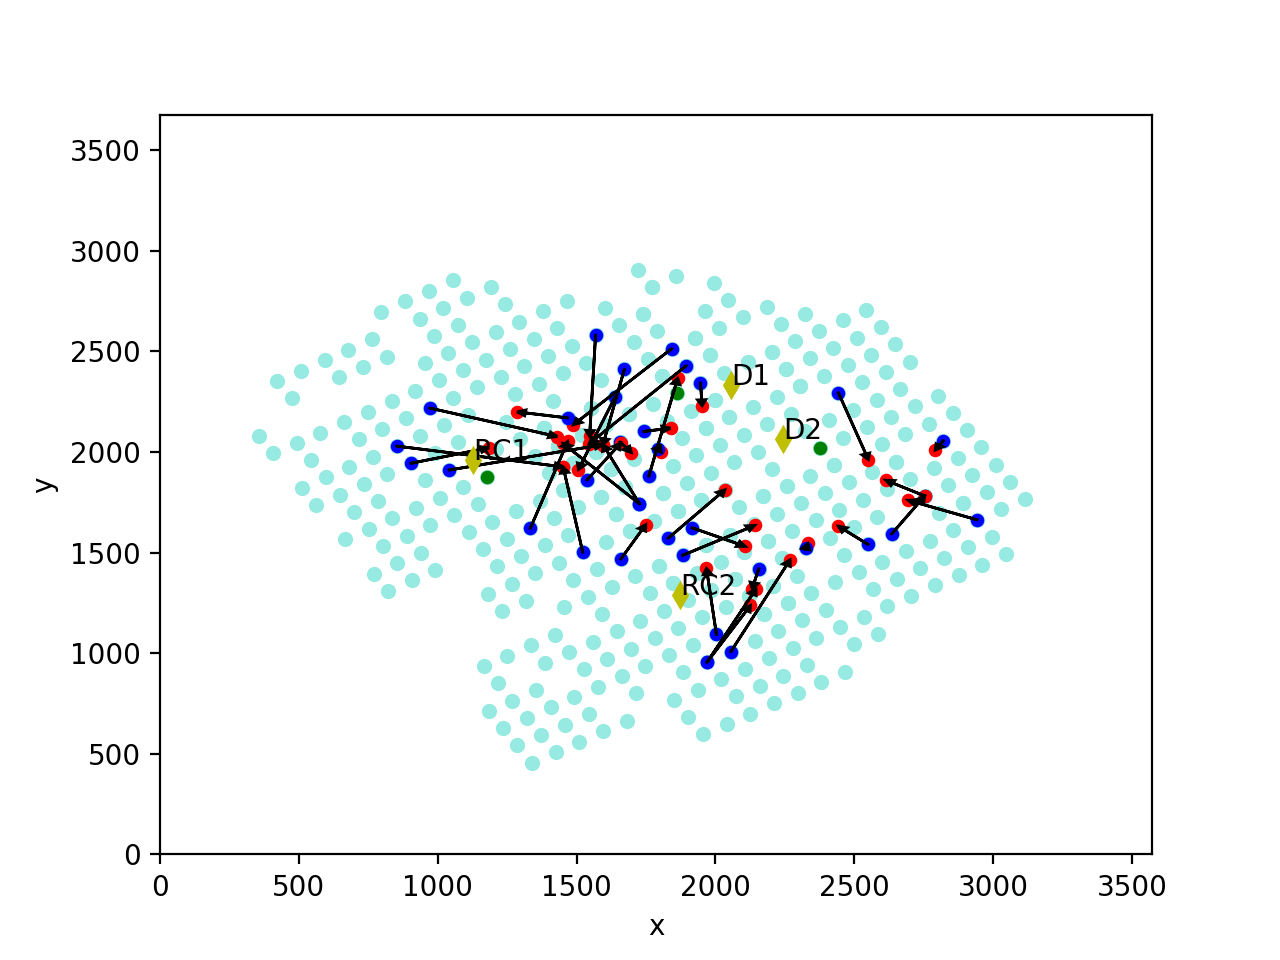

In [17]:
clf = KNeighborsRegressor(n_neighbors=5, weights='distance')
X_train, X_test, y_train, y_test = train_test_split(regre_data, regre_target, test_size=0.007)


clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

show_prediction_map_examples(predictions, np.array(y_test))

### Mapa con ejemplos de predicciones por punto

examining points [426, 304, 216]


<IPython.core.display.Javascript object>


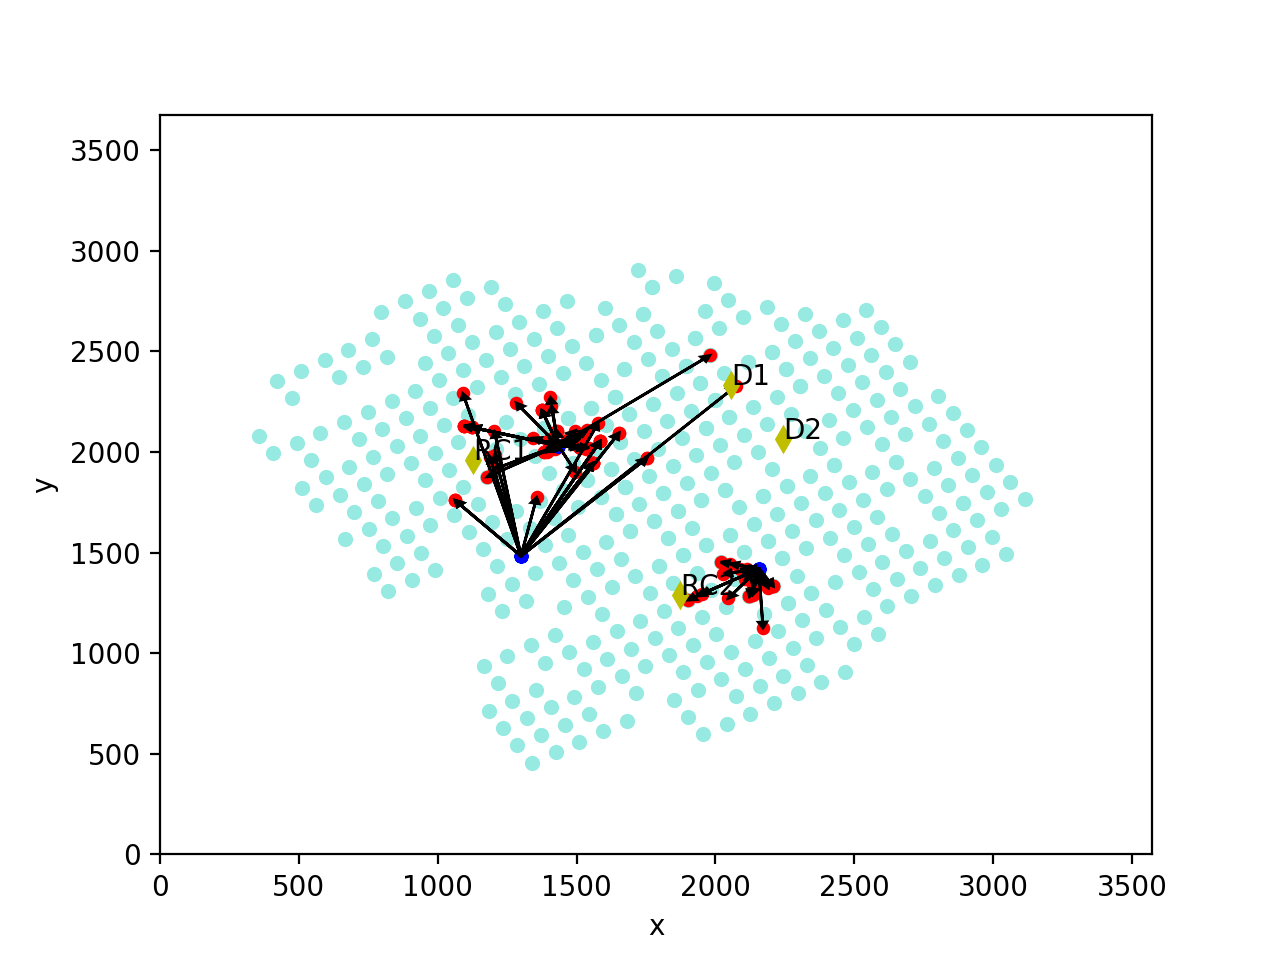

In [18]:
n = 3
sample_points = all_emissions.map(lambda x: x['point']).takeSample(False, n)
print('examining points', sample_points)

X_train = pd.DataFrame(all_emissions.filter(lambda x: x['point'] not in sample_points).map(lambda x: x['data']).collect())
y_train = pd.DataFrame(all_emissions.filter(lambda x: x['point'] not in sample_points).map(lambda x: [x['x'], x['y']]).collect())

X_test = pd.DataFrame(all_emissions.filter(lambda x: x['point'] in sample_points).map(lambda x: x['data']).collect())
y_test = pd.DataFrame(all_emissions.filter(lambda x: x['point'] in sample_points).map(lambda x: [x['x'], x['y']]).collect())




clf = KNeighborsRegressor(n_neighbors=5, weights='distance')

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

show_prediction_map_examples(predictions, np.array(y_test))